In [1]:
%matplotlib inline
import numpy as np
import scipy.ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import pandas as pd
import dask
import os.path
from __future__ import division
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)
matplotlib.rcParams['font.size'] = 16

from progress_bar import *
from useful import *

global data_dir
data_dir = '/scratch/ap587/dry_data/'


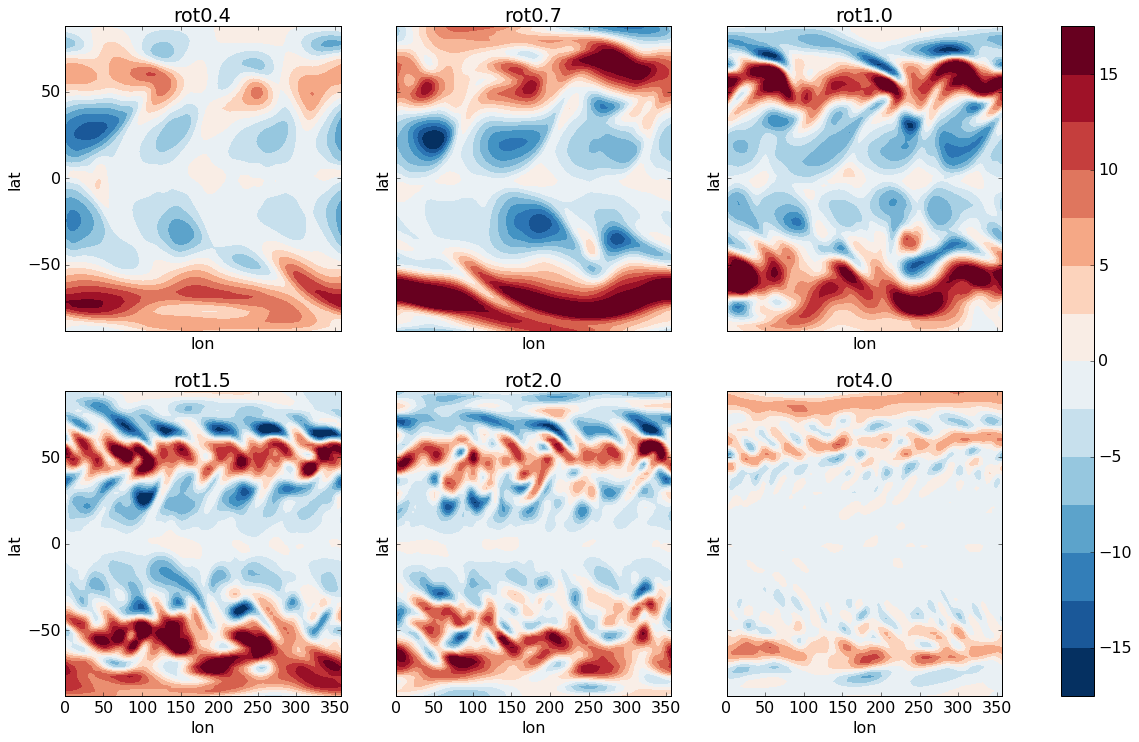

In [3]:
# plot lat-lon for some field at some height and time
exp = 'exp7' #exp8-ml2000'
exps = []
vals = []
for name in os.listdir(data_dir):
    if name.split('_')[0] == exp:
        exps += [name]
        vals += [name.split('_')[1]]

fig, axs = plt.subplots(2,3,figsize=(21,12),sharey=True,sharex=True)
for i, ax in enumerate(axs.reshape(-1)):
    ds = open_runset(data_dir,exps[i],runs=range(21,25))
    da = ds.ucomp.isel(time=None).isel(pfull=-1)
    if share_cb:
        if i==0:
            vmax = da.max().values
        im = da.plot.contourf(x='lon',y='lat', ax=ax, add_colorbar=None,vmax=vmax, levels=15)
    else:
        im = da.plot.contourf(x='lon',y='lat', ax=ax, levels=15)
    ax.set_title(vals[i])
    
if share_cb:
    fig.colorbar(im, ax=axs.ravel().tolist())

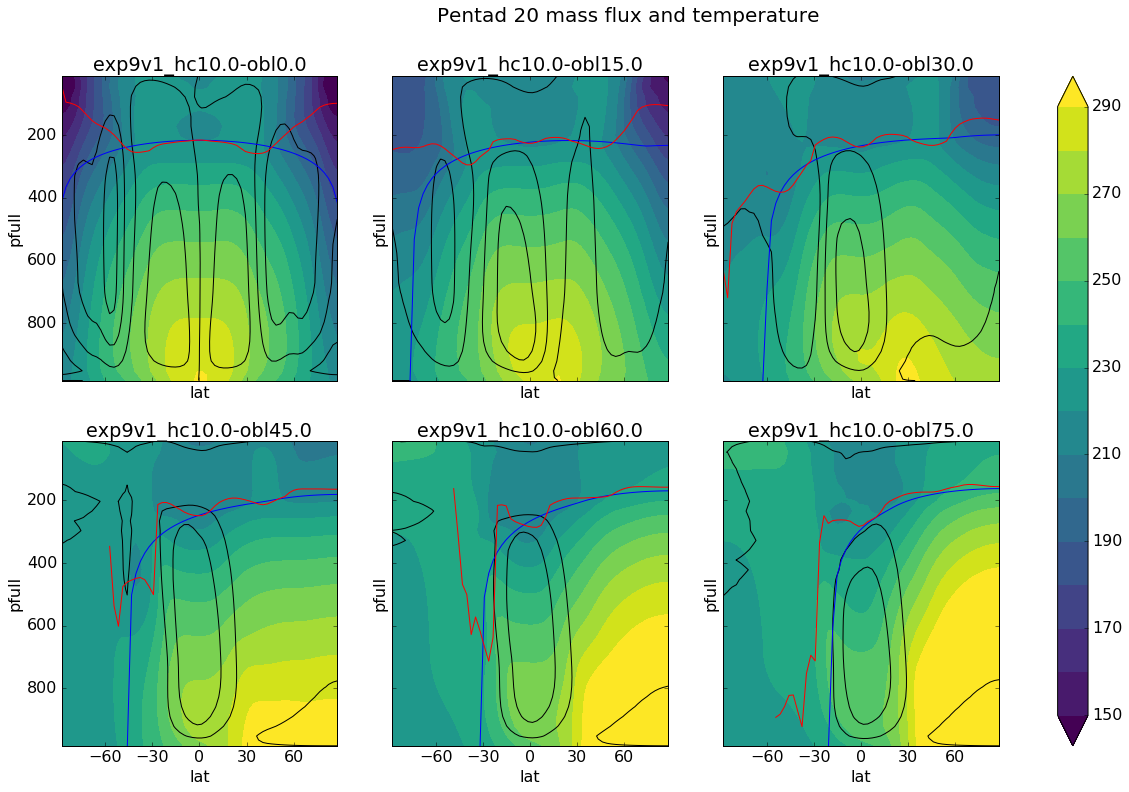

In [9]:
# plot lat-pfull for a selected experiment
exp = 'exp9v1' #exp8-ml2000'
exps = []
vals = []
for name in os.listdir(data_dir):
    if name.split('_')[0] == exp:
        exps += [name]
        vals += [name.split('_')[1]]
share_cb = 1

exps = ['exp9_hc10.0-obl0.0', 'exp9_hc10.0-obl20.0', 'exp9_hc10.0-obl40.0', 'exp9_hc10.0-obl60.0',
       'exp9_hc10.0-obl80.0', 'exp9_hc10.0-obl90.0']

exps = []
hcs = [10]
obls = np.arange(0,91,15)
for hc in hcs:
    for obl in obls:
        exps += ['exp9v1_hc{:.1f}-obl{:.1f}'.format(hc,obl)]
do_climatology = True
#exps = ['exp2_hc50.0', 'exp11_hc-ka0.5', 'exp11_hc-ka0.2']

season = 20
title_text = 'mean meridional mass flux'
if season is None:
    title_text = 'Annual mean mass flux and temperature'
else:
    title_text = 'Pentad %d ' % season + 'mass flux and temperature'
    
tlev = np.arange(150,300,10)
fig, axs = plt.subplots(2,3, figsize=(21,12),sharey=True, sharex=True)
for i, ax in enumerate(axs.reshape(-1)):
    if do_climatology:
        ds = open_climatology(data_dir, exps[i])
    else:
        ds = open_zmean_runset(data_dir, exps[i])
        ds = ds.isel(time=slice(720,None))
        lag = calc_seasonal_lag(ds.teq)
        if np.isnan(lag):
            lag = 0
        ds.coords['day'] = (ds.day-lag+45)%360
        ds.coords['season'] = np.floor(ds.day/90)
        ds = ds.groupby('season').mean('time')
    if season is None:
        print('Annual Mean')
        ds = ds.mean('pentad')
    else:
        ds = ds.isel(pentad=season)
    if share_cb:
        if i==0:
            levels = [-15e10, -12e10, -9e10, -6e10,-5e10, -4e10, -3e10, -2e10, -1e10, 1e10, 2e10, 3e10, 4e10,5e10, 6e10, 9e10, 12e10, 15e10]
        im = ds.temp.plot.contourf(x='lat',y='pfull', ax=ax, add_colorbar=None,levels=tlev,extend='both')
        ds.psi.plot.contour(x='lat',y='pfull',ax=ax,add_colorbar=None,colors='k')#,levels=levels)
        ax.plot(ds.lat.values, ds.p_trop.values)
        ax.plot(ds.lat.values, ds.p_trop_calc.values, 'r')        
    else:
        im = ds.psi.plot.contourf(x='lat',y='pfull', ax=ax, levels=15)
    ax.set_title(exps[i][:])
    ax.set_xticks(np.arange(-60,61,30))

if share_cb:
    fig.colorbar(im, ax=axs.ravel().tolist())
plt.gca().invert_yaxis()    
fig.suptitle(title_text, fontsize=20)

In [27]:
itcz = 12
a = ds.h_trop.sel(lat=np.arange(itcz-10,itcz+10,ds.lat[2]-ds.lat[1]),method='nearest')


print np.array((43, 23))

[215 115]


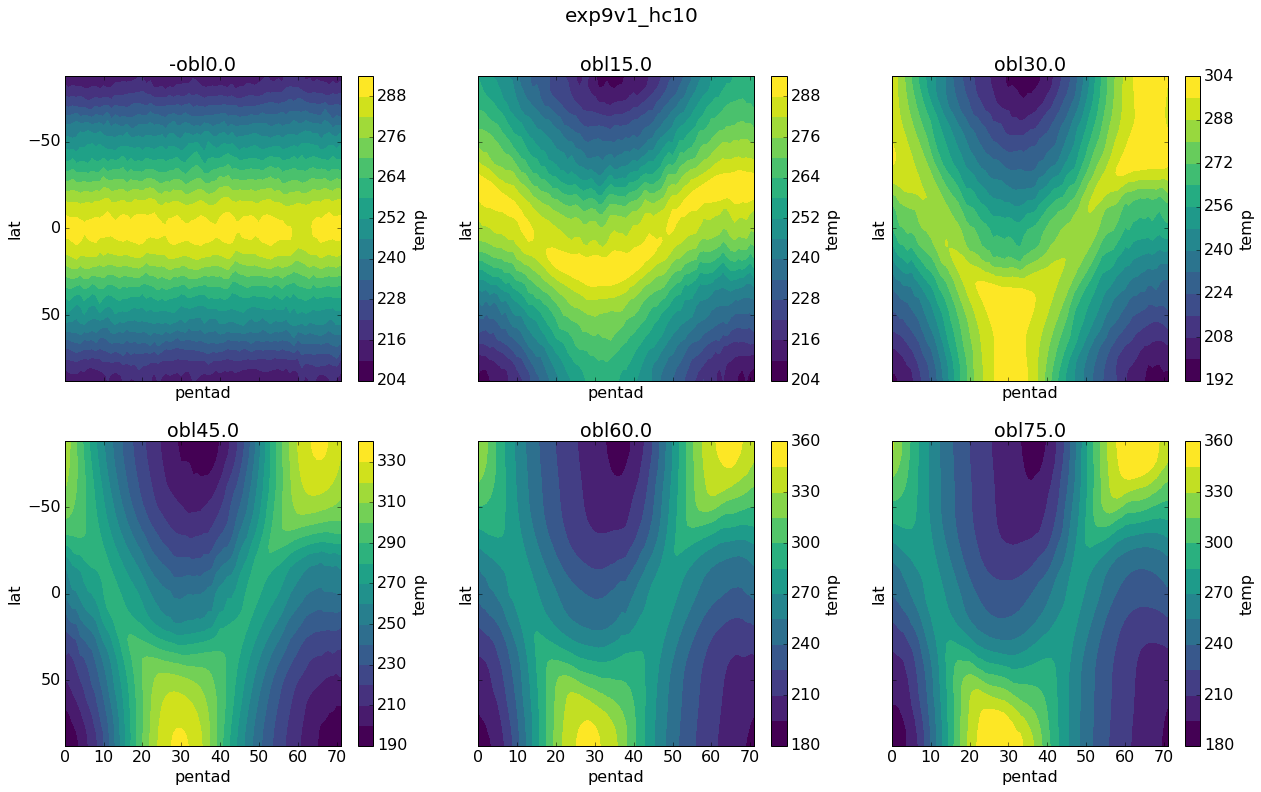

In [29]:
# plot timeseries for a selected climatology
exp = 'exp8-ml50'
exps = []
vals = []
for name in os.listdir(data_dir):
    if name.split('_')[0] == exp:
        exps += [name]
        vals += [name.split('_')[1]]
share_cb = 0
title_text = exp+' surface temperatures'

exps = []
hcs = [10]
obls = np.arange(0,91,15)
for hc in hcs:
    for obl in obls:
        exps += ['exp9v1_hc{:.1f}-obl{:.1f}'.format(hc,obl)]
title_text = exps[0][0:11]

fig, axs = plt.subplots(2,3, figsize=(21,12),sharey=True, sharex=True)
for i, ax in enumerate(axs.reshape(-1)):
    ds = open_climatology(data_dir, exps[i])
    if 'quintad' in ds.keys():
        ds.rename({'quintad':'pentad'}, inplace=True)
    da = ds.psi.sel(pfull=800, method='nearest')
    da = ds.temp.isel(pfull=-1)  #choose the data array to plot
    if share_cb:
        if i==0:
            vmax = da.max().values
        im = da.plot.contourf(x='pentad',y='lat', ax=ax, add_colorbar=None,vmax=vmax, levels=15)
    else:
        im = da.plot.contourf(x='pentad',y='lat', ax=ax, levels=15)
    ax.set_title(exps[i][-7:])

if share_cb:
    fig.colorbar(im, ax=axs.ravel().tolist())
plt.gca().invert_yaxis()    
fig.suptitle(title_text, fontsize=20)

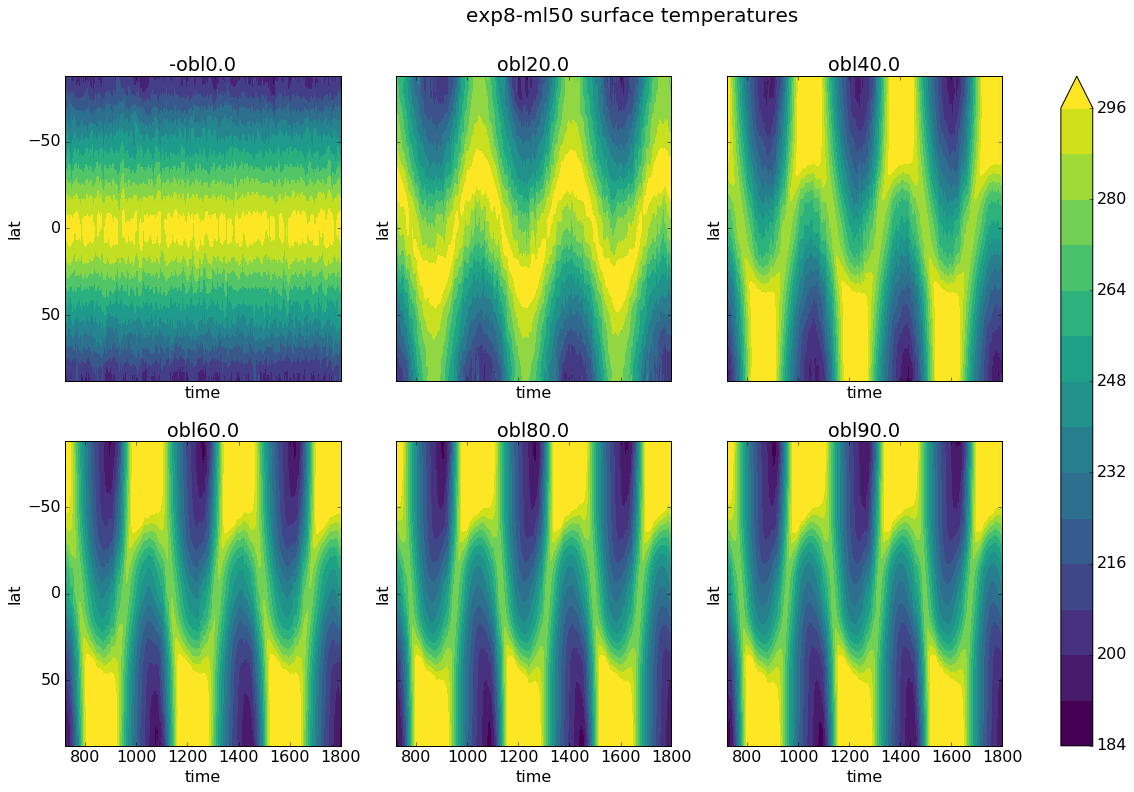

In [28]:
# plot some timeseries for a selected experiment
exp = 'exp8-ml50'
exps = []
vals = []
for name in os.listdir(data_dir):
    if name.split('_')[0] == exp:
        exps += [name]
        vals += [name.split('_')[1]]
share_cb = 1
title_text = exp+' surface temperatures'

exps = ['exp9_hc10.0-obl0.0', 'exp9_hc10.0-obl20.0', 'exp9_hc10.0-obl40.0', 'exp9_hc10.0-obl60.0',
       'exp9_hc10.0-obl80.0', 'exp9_hc10.0-obl90.0']

fig, axs = plt.subplots(2,3, figsize=(21,12),sharey=True, sharex=True)
for i, ax in enumerate(axs.reshape(-1)):
    ds = open_zmean_runset(data_dir, exps[i])
    da = ds.psi.isel(time=slice(720,None)).mean('time')
    da = ds.temp.isel(time=slice(720,None)).isel(pfull=-1)  #choose the data array to plot
    if share_cb:
        if i==0:
            vmax = da.max().values
        im = da.plot.contourf(x='time',y='lat', ax=ax, add_colorbar=None,vmax=vmax, levels=15)
    else:
        im = da.plot.contourf(x='time',y='lat', ax=ax, levels=15)
    ax.set_title(exps[i][-7:])

if share_cb:
    fig.colorbar(im, ax=axs.ravel().tolist())
plt.gca().invert_yaxis()    
fig.suptitle(title_text, fontsize=20)

Annual Mean


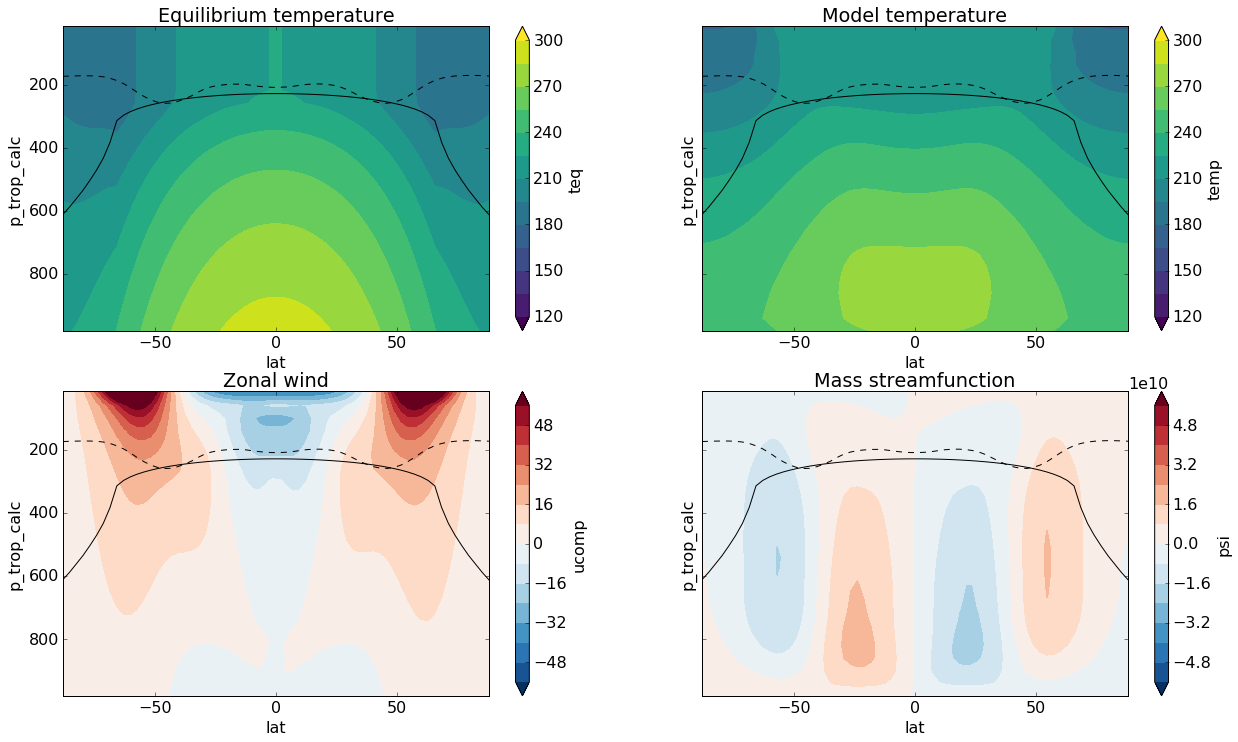

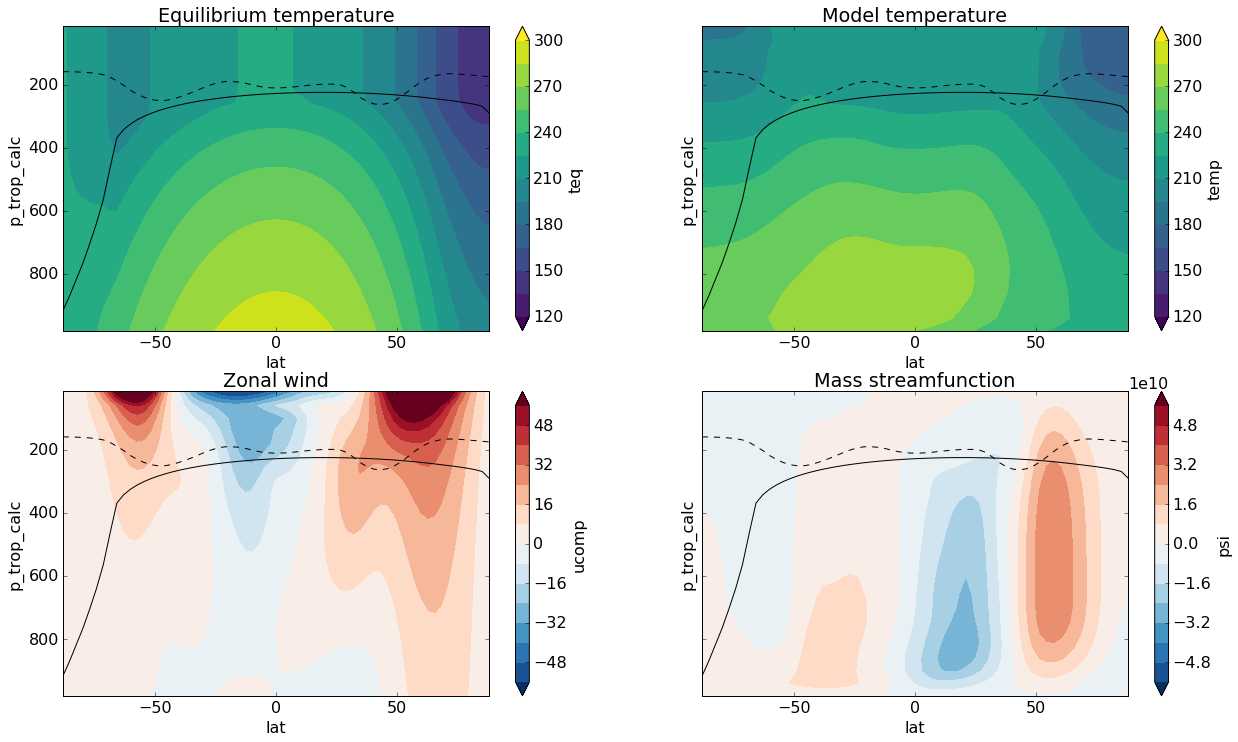

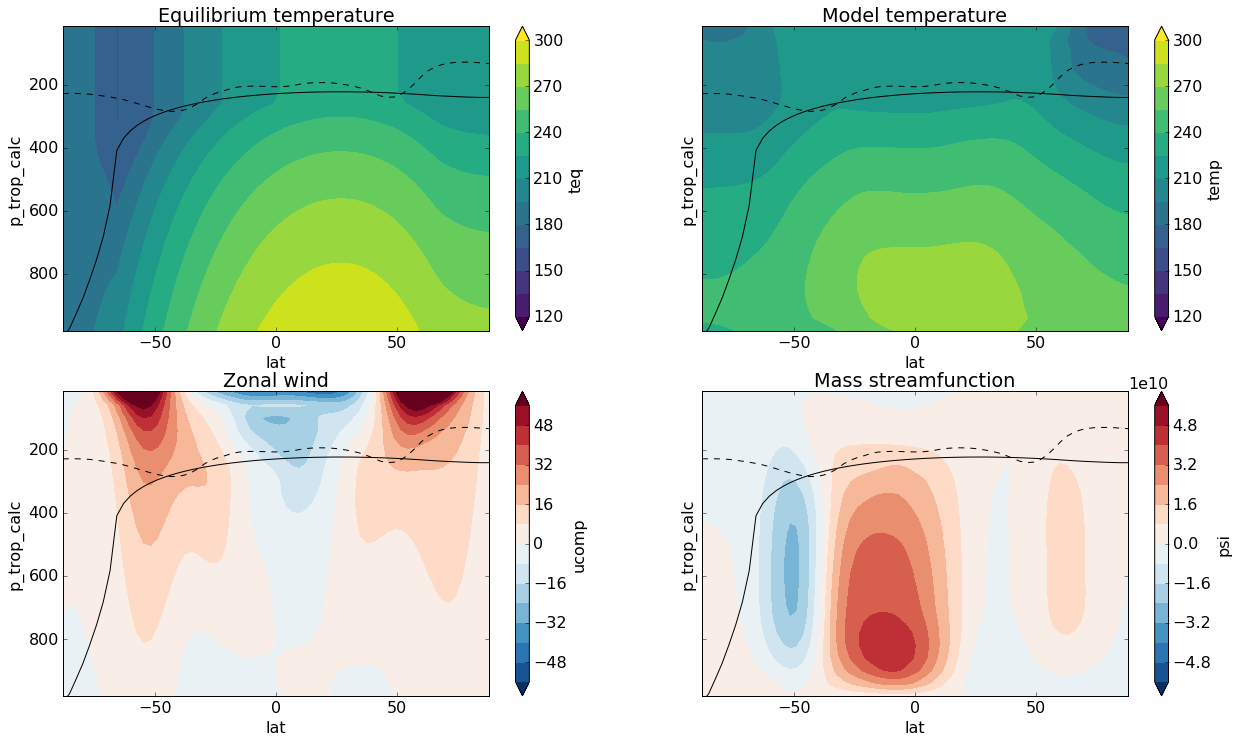

In [32]:
# ----- Run plot_grid for a list of experiments -----

exps = ['exp9_hc50.0-obl90.0']
exps = ['exp11_hc-ka0.2']

seasons = [None,0,1]

for i, exp in enumerate(exps):
    for season in seasons:
        ds = open_zmean_runset(data_dir, exps[i])
        ds = ds.isel(time=slice(720,None))
        lag = calc_seasonal_lag(ds.teq)
        if np.isnan(lag):
            lag = 0
        ds.coords['day'] = (ds.day-lag+45)%360
        ds.coords['season'] = np.floor(ds.day/90)
        ds = ds.groupby('season').mean('time')
        if season is None:
            print('Annual Mean')
            ds = ds.mean('season')
        else:
            ds = ds.isel(season=season)
            
        plot_grid(ds)

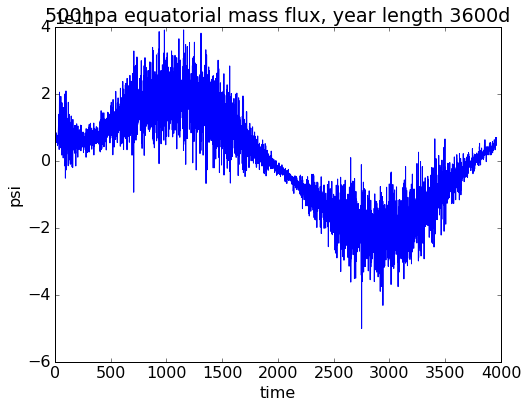

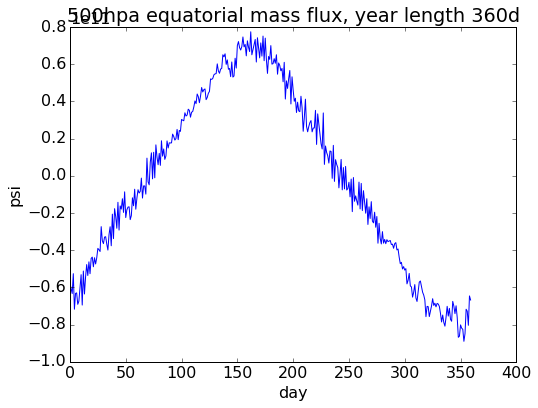

In [15]:
exps = ['exp6_yl10.0', 'exp2_hc30.0']

fig, ax = plt.subplots()
ds = open_zmean_runset(data_dir,exps[0])
ds.psi.sel(pfull=500,method='nearest').sel(lat=0,method='nearest').plot(ax=ax)
ax.set_title('500hpa equatorial mass flux, year length 3600d')

fig, ax1 = plt.subplots()
ds = open_zmean_runset(data_dir,exps[1])
ds = ds.groupby('day').mean('time')
ds.psi.sel(pfull=500,method='nearest').sel(lat=0,method='nearest').plot(ax=ax1)
ax1.set_title('500hpa equatorial mass flux, year length 360d')

In [ ]:
exps = ['exp2_hc1.0', 'exp2_hc10.0', 'exp2_hc50.0', 'exp2_hc500.0']
fig, ax = plt.subplots()
for exp in exps:
    ds = open_zmean_runset(data_dir,exp)
    ds.psi.sel(pfull=500,method='nearest').sel(lat=0,method='nearest').groupby('day').mean('time').plot(ax=ax, label=exp[2:])

ax.legend()

In [ ]:
exps = ['exp2_hc1.0', 'exp2_hc10.0', 'exp2_hc50.0', 'exp2_hc500.0']
exps = ['exp5_obl0.0', 'exp5_obl30.0', 'exp5_obl60.0', 'exp5_obl90.0']
vmin=220
vmax=290
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(21,15), sharey=True)
for i, ax in enumerate(axes.flat):
    ds = open_zmean_runset(data_dir, exps[i])
    im = ds.temp.isel(time=slice(720,None)).isel(pfull=-1).groupby('day').mean('time').plot.contourf(x='day',y='lat',vmin=vmin,vmax=vmax,levels=15, extend='both',add_colorbar=False, ax=ax)
    ax.set_title('obliquity ' + exps[i][5:-2] + ' degrees')

cax,kw = matplotlib.colorbar.make_axes([ax for ax in axes.flat])
plt.colorbar(im, cax=cax, **kw)


In [ ]:
exps = ['exp2_hc1.0', 'exp2_hc10.0', 'exp2_hc50.0', 'exp2_hc500.0']
#exps = ['5_obl0.0', '5_obl30.0', '5_obl60.0', '5_obl90.0']
vmin=None
vmax=None
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(21,15), sharey=True)
for i, ax in enumerate(axes.flat):
    ds = open_zmean_runset(data_dir, exps[i])
    lag_cor = calc_seasonal_lag(ds.teq)
    n_eq = (np.append(np.arange(0,45), np.arange(315,360)) + lag_cor)%360
    n_sum = (np.arange(45,135) + lag_cor)%360
    sum_sel = np.append(n_sum, np.append(n_sum+360, np.append(n_sum+360*2, n_sum+360*3)))
    eq_sel = np.append(n_eq, np.append(n_eq+360, np.append(n_eq+360*2, n_eq+360*3)))
    sel = slice(None,None)
    im = ds.psi.isel(time=slice(720,None)).isel(time=sum_sel).mean('time').plot.contourf(x='lat',y='pfull',vmin=vmin,vmax=vmax,levels=15, extend='both',add_colorbar=True, ax=ax)
    ax.set_title('ML depth ' + exps[i][4:-2] + 'm')

plt.gca().invert_yaxis()
#cax,kw = matplotlib.colorbar.make_axes([ax for ax in axes.flat])
#plt.colorbar(im, cax=cax, **kw)


In [ ]:
exp = 'exp3_hc50.0'
ds = open_zmean_runset(data_dir,exp)
ds = ds.isel(time=slice(720,None))
lag_cor = calc_seasonal_lag(ds.teq)  
#plot_timeseries(c)    
n_eq = (np.append(np.arange(0,45), np.arange(315,360)) + lag_cor)%360
n_sum = (np.arange(45,135) + lag_cor)%360
s_eq = (np.arange(135,225) + lag_cor)%360
n_win = (np.arange(225,315) + lag_cor)%360
sum_sel = np.append(n_sum, np.append(n_sum+360, np.append(n_sum+360*2, n_sum+360*3)))
win_sel = np.append(n_win, np.append(n_win+360, np.append(n_win+360*2, n_win+360*3)))
eq_sel = np.append(n_eq, np.append(n_eq+360, np.append(n_eq+360*2, n_eq+360*3)))
eq_sel2 = np.append(s_eq, np.append(s_eq+360, np.append(s_eq+360*2, s_eq+360*3)))
lcm = np.array([lag_cor-1, lag_cor, lag_cor+1])

plot_grid(ds, do_tp=0, vmaxsf=0.5e11)

In [ ]:
exps = ['exp2_hc1.0', 'exp2_hc10.0', 'exp2_hc50.0', 'exp2_hc500.0']
dsl = []
for exp in exps:
    dsl = dsl + [open_zmean_runset(data_dir,exp)]

fig, ax = plt.subplots()
for i, ds in enumerate(dsl):
    ds.psi.sel(lat=0, method='nearest').sel(pfull=500, method='nearest').groupby('day').mean('time').plot(label=exps[i][2:-2])
plt.legend()

In [ ]:
'''Held and Suarez Comparison'''
exps = ['exp1_HS1', 'exp4_HS_hc500.0']
titles = ['Held and Suarez forcing (no seasons)', 'Modified forcing, high heat capacity']
for i, exp in enumerate(exps):
    ds = open_zmean_runset(data_dir,exp)
    plot_grid(ds, do_tp=0, title_text=titles[i])

In [ ]:
print ds

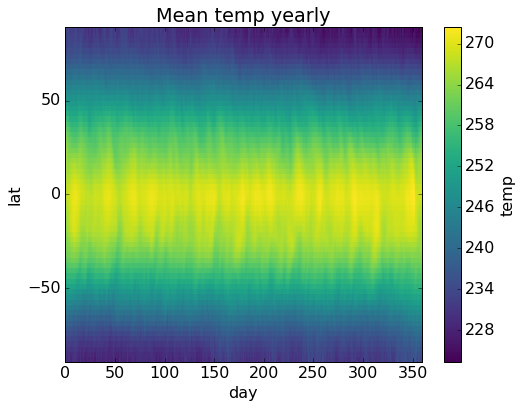

In [19]:
ds = open_zmean_runset(data_dir, exps[0])

ds.temp.isel(time=slice(720,None)).groupby('day').mean('time').isel(pfull=-1).plot(
    x='day', y='lat')
plt.title('Mean temp yearly')